In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import osmnx as ox
import pandas as pd
import pickle
import tensorflow as tf

In [2]:
tf.__version__

'1.12.0'

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Load the model
Load the training supposed best training checkpoint. Then put the weight into a newly generated model that can handel a single batch.

In [4]:
DATASET_NAME = 'cabspotting'
setup_string = 'GRU-1024_TD-Dense-3_{dataset}_64_100_adam_mae_default'.format(dataset=DATASET_NAME)

In [5]:
setup_string

'GRU-1024_TD-Dense-3_cabspotting_64_100_adam_mae_default'

In [6]:
history = pickle.load(open('histories/citybased_rnn/' + setup_string + '_30.pkl', 'rb'))

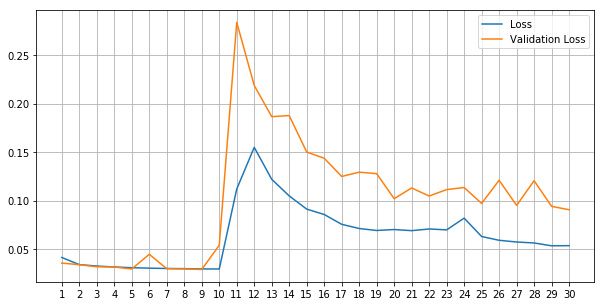

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 31, 1), history['loss'], label='Loss')
plt.plot(np.arange(1, 31, 1), history['val_loss'], label='Validation Loss')
plt.xticks(np.arange(1, 31, 1))
plt.grid()
plt.legend()
plt.show()

In [8]:
SELECTED_EPOCH = 9

In [9]:
# Load the model
model_path = 'checkpoints/citybased_rnn/' + setup_string + '_{:02}.h5'.format(SELECTED_EPOCH)
loaded_model = tf.keras.models.load_model(model_path)

In [10]:
def build_model(batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.GRU(1024, return_sequences=True, stateful=True, input_shape=(None, 3), batch_size=batch_size),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3))
    ])
    return model

In [11]:
model = build_model(batch_size=1)
model.set_weights(loaded_model.get_weights())

## Actual generation

In [12]:
N_USERS = 8

Generate user start positions

In [13]:
poskde = pickle.load(open('../data_{dataset}/poskde_{dataset}_000003.pkl'.format(dataset=DATASET_NAME), 'rb'))

In [14]:
user_sposs = poskde.sample(N_USERS)

In [15]:
user_sposs

array([[-122.44453365,   37.75967793],
       [-122.40100081,   37.74961299],
       [-122.40259656,   37.79274655],
       [-122.39419113,   37.70538767],
       [-122.38756697,   37.61715669],
       [-122.4227193 ,   37.77496148],
       [-122.41890163,   37.78221967],
       [-122.42219733,   37.7884202 ]])

Generate start and end times

In [16]:
BEGIN = pd.Timestamp('2008-05-17 10:00:04')
END = pd.Timestamp('2008-06-10 09:25:34')
duration = END - BEGIN

In [17]:
sekde = pickle.load(open('../data_{dataset}/sekde_{dataset}_003.pkl'.format(dataset=DATASET_NAME), 'rb'))

In [18]:
user_begins = sekde['kde_start'].sample(N_USERS)
user_begins = user_begins * duration.total_seconds()

In [19]:
user_ends = sekde['kde_end'].sample(N_USERS)
user_ends = user_ends * duration.total_seconds()

Put correctly scaled start records and end times together

In [20]:
scaler = pickle.load(open('scalers/citybased_rnn/' + setup_string + '.pkl', 'rb'))

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [21]:
starts = np.concatenate([user_begins, user_sposs], axis=1)
starts = scaler.transform(starts)

In [22]:
endtimes = scaler.transform(np.concatenate([user_ends, np.zeros([len(user_ends), 2])], axis=1))[:, 0]

Actual generation loops

In [33]:
def generate_user(generator, start, endtime):
    generator.reset_states()
    s = np.array([start]).astype(np.float32)
    
    while(s[-1][0] <= endtime):
        print(' -> {} <= {}'.format(s[-1][0], endtime))
        x = s[-1:]
        x = np.array([x])
        
        y = model.predict(x, batch_size=1)
    
        y = np.squeeze(y, axis=0)
        s = np.concatenate([s, y])
    
    return s[:-1]

In [34]:
data = []
for u in range(N_USERS):
    print(u)
    s = generate_user(model, starts[u], endtimes[u])
    data.append(s)

0
 -> -1.661403775215149 <= 1.5046584627609323
 -> -1.754089593887329 <= 1.5046584627609323
 -> -1.7127325534820557 <= 1.5046584627609323
 -> -1.6706560850143433 <= 1.5046584627609323
 -> -1.6444003582000732 <= 1.5046584627609323
 -> -1.6293641328811646 <= 1.5046584627609323
 -> -1.6232798099517822 <= 1.5046584627609323
 -> -1.6228830814361572 <= 1.5046584627609323
 -> -1.626387596130371 <= 1.5046584627609323
 -> -1.6315573453903198 <= 1.5046584627609323
 -> -1.6370537281036377 <= 1.5046584627609323
 -> -1.6423132419586182 <= 1.5046584627609323
 -> -1.6474978923797607 <= 1.5046584627609323
 -> -1.6529008150100708 <= 1.5046584627609323
 -> -1.6587092876434326 <= 1.5046584627609323
 -> -1.6649075746536255 <= 1.5046584627609323
 -> -1.6712942123413086 <= 1.5046584627609323
 -> -1.6776505708694458 <= 1.5046584627609323
 -> -1.6838839054107666 <= 1.5046584627609323
 -> -1.690011978149414 <= 1.5046584627609323
 -> -1.6961040496826172 <= 1.5046584627609323
 -> -1.7022314071655273 <= 1.5046584

 -> -2.2321248054504395 <= 1.5046584627609323
 -> -2.2328014373779297 <= 1.5046584627609323
 -> -2.2334704399108887 <= 1.5046584627609323
 -> -2.234131097793579 <= 1.5046584627609323
 -> -2.2347829341888428 <= 1.5046584627609323
 -> -2.235426902770996 <= 1.5046584627609323
 -> -2.23606276512146 <= 1.5046584627609323
 -> -2.2366905212402344 <= 1.5046584627609323
 -> -2.2373106479644775 <= 1.5046584627609323
 -> -2.2379226684570312 <= 1.5046584627609323
 -> -2.238527297973633 <= 1.5046584627609323
 -> -2.2391254901885986 <= 1.5046584627609323
 -> -2.239715099334717 <= 1.5046584627609323
 -> -2.24029803276062 <= 1.5046584627609323
 -> -2.2408742904663086 <= 1.5046584627609323
 -> -2.2414426803588867 <= 1.5046584627609323
 -> -2.242003917694092 <= 1.5046584627609323
 -> -2.242558240890503 <= 1.5046584627609323
 -> -2.2431063652038574 <= 1.5046584627609323
 -> -2.243647575378418 <= 1.5046584627609323
 -> -2.2441821098327637 <= 1.5046584627609323
 -> -2.2447094917297363 <= 1.5046584627609323

 -> -2.2765872478485107 <= 1.5046584627609323
 -> -2.2766027450561523 <= 1.5046584627609323
 -> -2.2766177654266357 <= 1.5046584627609323
 -> -2.276632308959961 <= 1.5046584627609323
 -> -2.276646375656128 <= 1.5046584627609323
 -> -2.2766599655151367 <= 1.5046584627609323
 -> -2.2766733169555664 <= 1.5046584627609323
 -> -2.276686668395996 <= 1.5046584627609323
 -> -2.2766995429992676 <= 1.5046584627609323
 -> -2.2767114639282227 <= 1.5046584627609323
 -> -2.276723861694336 <= 1.5046584627609323
 -> -2.276736259460449 <= 1.5046584627609323
 -> -2.2767481803894043 <= 1.5046584627609323
 -> -2.2767601013183594 <= 1.5046584627609323
 -> -2.2767720222473145 <= 1.5046584627609323
 -> -2.2767834663391113 <= 1.5046584627609323
 -> -2.27679443359375 <= 1.5046584627609323
 -> -2.2768049240112305 <= 1.5046584627609323
 -> -2.276815891265869 <= 1.5046584627609323
 -> -2.2768261432647705 <= 1.5046584627609323
 -> -2.276836633682251 <= 1.5046584627609323
 -> -2.2768468856811523 <= 1.50465846276093

 -> -2.2772531509399414 <= 1.5046584627609323
 -> -2.2772536277770996 <= 1.5046584627609323
 -> -2.277254104614258 <= 1.5046584627609323
 -> -2.277254819869995 <= 1.5046584627609323
 -> -2.2772552967071533 <= 1.5046584627609323
 -> -2.2772557735443115 <= 1.5046584627609323
 -> -2.277256488800049 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.504658462760932

 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -

 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.277258

 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.2772696018218994 <= 1.5046584627609323
 -> -2.2772698402404785 <= 1.5046584627609323
 -> -2.2772698402404785 <= 1.5046584627609323
 -> -2.2772698402404785 <= 1.5046584627609323
 -> -2.2772698402404785 <= 1.5046584627609323
 -> -2.2772698402404785 <= 1.5046584627609323
 -> -2.2772698402404785 <= 1.5046584627609323
 -> -2.2772698402404785 <= 1.5046584627609323
 -> -2.2772696018218994 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.2772696018218994 <= 1.5046584627609323
 -> -2.2772698402404785 <= 1.5046584627609323
 -> -2.2772698402404785 <= 1.5046584627609323
 -> -2.2772698402404785 <= 1.5046584627609323
 -> -2.2772698402404785 <= 1.50465

 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323


 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -

 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772648334503174 <= 1.5046584627609323
 -> -2.2772648334503174 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772648334503174 <= 1.5046584627609323
 -> -2.2772648334503174 <= 1.5046584627609323
 -> -2.2772648334503174 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772653102874756 <= 1.5046584627609323
 -> -2.2772653102874756 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772672176361084 <= 1.50465846

 -> -2.277264356613159 <= 1.5046584627609323
 -> -2.277264356613159 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772653102874756 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.277265787124634 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.277265787124634 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -

 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.2772624492645264 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772629261016846 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772648334503174 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772648334503174 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772653102874756 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.277266263961792 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323

 -> -2.2772557735443115 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.5046584627609323
 -> -2.2772562503814697 <= 1.5046584627609323
 -> -2.277256488800049 <= 1.5046584627609323
 -> -2.277256727218628 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277257204055786 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.504658462760

 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277

 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.50465

 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277257204055786 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> 

 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772672176361084 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.277268886566162 <= 1.5046584627609323
 -> -2.277268886566162 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.2772696018218994 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.504658462760

 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.277265787124634 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772648334503174 <= 1.5046584627609323
 -> -2.2772648334503174 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772648334503174 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584

 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.2772676944732666 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772672176361084 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772672176361084 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.5046584627609323
 

 -> -2.2772727012634277 <= 1.5046584627609323
 -> -2.2772727012634277 <= 1.5046584627609323
 -> -2.2772727012634277 <= 1.5046584627609323
 -> -2.2772727012634277 <= 1.5046584627609323
 -> -2.2772722244262695 <= 1.5046584627609323
 -> -2.2772722244262695 <= 1.5046584627609323
 -> -2.2772724628448486 <= 1.5046584627609323
 -> -2.2772724628448486 <= 1.5046584627609323
 -> -2.2772724628448486 <= 1.5046584627609323
 -> -2.2772724628448486 <= 1.5046584627609323
 -> -2.2772724628448486 <= 1.5046584627609323
 -> -2.2772724628448486 <= 1.5046584627609323
 -> -2.2772724628448486 <= 1.5046584627609323
 -> -2.2772727012634277 <= 1.5046584627609323
 -> -2.2772727012634277 <= 1.5046584627609323
 -> -2.2772727012634277 <= 1.5046584627609323
 -> -2.2772724628448486 <= 1.5046584627609323
 -> -2.2772722244262695 <= 1.5046584627609323
 -> -2.2772722244262695 <= 1.5046584627609323
 -> -2.2772717475891113 <= 1.5046584627609323
 -> -2.2772717475891113 <= 1.5046584627609323
 -> -2.2772722244262695 <= 1.50465

 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 

 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609

 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.50465846276

 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.277261972427368 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627

 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.277257204055786 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256488800049 <= 1.5046584627609323
 -> -2.277256488800049 <= 1.5046584627609323
 -> -2.277256488800049 <= 1.5046584627609323
 -> -2.277256488800049 <= 1.5046584627609323
 -> -2.277256488800049 <= 1.5046584627609323
 -> -2.277256488800049 <= 1.5046584627609

 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.277257204055786 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.504658

 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298

 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.2772624492645264 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2

 -> -2.2772703170776367 <= 1.5046584627609323
 -> -2.2772700786590576 <= 1.5046584627609323
 -> -2.2772698402404785 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.277269124984741 <= 1.5046584627609323
 -> -2.277268886566162 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.277268171310425 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.277268171310425 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.277268171310425 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.2772676944732666 <= 1.5046584627609323


 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.277261972427368 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -

 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772600650787354 <= 1.5046584627609323
 -> -2.2772600650787354 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772600650787354 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -

 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261972427368 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772624492645264 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323


 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.504658462760

 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772600650787354 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.50465846276

 -> -2.2772672176361084 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772676944732666 <= 1.5046584627609323
 -> -2.2772676944732666 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772672176361084 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266263961792 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772672176361084 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323

 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.

 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772672176361084 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266263961792 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266263961792 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266263961792 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266263961792 <= 1.5046584627609323
 -> -2.277265787124634 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2

 -> -2.2772724628448486 <= 1.5046584627609323
 -> -2.2772722244262695 <= 1.5046584627609323
 -> -2.2772719860076904 <= 1.5046584627609323
 -> -2.2772719860076904 <= 1.5046584627609323
 -> -2.2772719860076904 <= 1.5046584627609323
 -> -2.2772717475891113 <= 1.5046584627609323
 -> -2.2772717475891113 <= 1.5046584627609323
 -> -2.2772722244262695 <= 1.5046584627609323
 -> -2.2772722244262695 <= 1.5046584627609323
 -> -2.2772722244262695 <= 1.5046584627609323
 -> -2.2772722244262695 <= 1.5046584627609323
 -> -2.2772719860076904 <= 1.5046584627609323
 -> -2.2772717475891113 <= 1.5046584627609323
 -> -2.277271270751953 <= 1.5046584627609323
 -> -2.277271270751953 <= 1.5046584627609323
 -> -2.277271270751953 <= 1.5046584627609323
 -> -2.277271270751953 <= 1.5046584627609323
 -> -2.277270793914795 <= 1.5046584627609323
 -> -2.277270793914795 <= 1.5046584627609323
 -> -2.277270793914795 <= 1.5046584627609323
 -> -2.2772703170776367 <= 1.5046584627609323
 -> -2.2772703170776367 <= 1.504658462760

 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772653102874756 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772648334503174 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772648334503174 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266263961792 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.504658462760

 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.27725

 -> -2.2772722244262695 <= 1.5046584627609323
 -> -2.2772722244262695 <= 1.5046584627609323
 -> -2.2772722244262695 <= 1.5046584627609323
 -> -2.2772722244262695 <= 1.5046584627609323
 -> -2.2772722244262695 <= 1.5046584627609323
 -> -2.2772724628448486 <= 1.5046584627609323
 -> -2.2772727012634277 <= 1.5046584627609323
 -> -2.277272939682007 <= 1.5046584627609323
 -> -2.277273416519165 <= 1.5046584627609323
 -> -2.277273654937744 <= 1.5046584627609323
 -> -2.2772738933563232 <= 1.5046584627609323
 -> -2.2772741317749023 <= 1.5046584627609323
 -> -2.2772738933563232 <= 1.5046584627609323
 -> -2.277273654937744 <= 1.5046584627609323
 -> -2.277273416519165 <= 1.5046584627609323
 -> -2.277273178100586 <= 1.5046584627609323
 -> -2.277272939682007 <= 1.5046584627609323
 -> -2.2772727012634277 <= 1.5046584627609323
 -> -2.277272939682007 <= 1.5046584627609323
 -> -2.277272939682007 <= 1.5046584627609323
 -> -2.2772727012634277 <= 1.5046584627609323
 -> -2.2772727012634277 <= 1.50465846276093

 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261972427368 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.2772624492645264 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772631645202637 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.277263879776001 <= 1.5046584627609323
 -> -2.277264356613159 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.504658462760932

 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772672176361084 <= 1.5046584627609323
 -> -2.2772672176361084 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.277268171310425 <= 1.5046584627609323
 -> -2.277268171310425 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.277268171310425 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.277268886566162 <= 1.5046584627609323
 -> -2.277268886566162 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.2772696018218994 <= 1.5046584627609323
 -> -2.2772703170776367 <= 1.5046584627609323
 -> -2.277270555496216 <= 1.5046584627609323
 -> -2.277270555496216 <= 1.5046584627609323
 -> -2.277270793914795 <= 1.50465846276093

 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2

 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -

 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.2772672176361084 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772676944732666 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.277268648147583 <= 1.5046584627609323
 -> -2.277268886566162 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.2772698402404785 <= 1.5046584627609323
 -> -2.2772703170776367 <= 1.5046584627609323
 -> -2.2772703170776367 <= 1.5046584627609323
 -> -2.2772703170776367 <= 1.5046584627609323
 -> -2.2772703170776367 <= 1.5046584627609323
 -> -2.277270793914795 <= 1.5046584627609323
 -> -2.277270793914795 <= 1.5046584627609323
 -> -2.277271032333374 <= 1.5046584627609323
 -> -2.277271270751953 <= 1.5046584627609323
 -> -2.2772715091705322 <= 1.5046584627609323
 -> -2.2772717475891113 <= 1.5046584627609323
 -> -2.2772717475891113 <= 1.5046584627609323
 -> -2.2772717475891113 <= 1.50465846276093

 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.2772

 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> 

 -> -2.277268171310425 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772648334503174 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.277263879776001 <= 1.504658462760

 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277257204055786 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.50465846

 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -

 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.277261972427368 <= 1.5046584627609323
 -> -2.277261972427368 <= 1.5046584627609323
 -> -2.277261972427368 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261972427368 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.277261972427368 <= 1.5046584627609323
 -> -

 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323

 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261972427368 <= 1.5046584627609323
 -> -2.277261972427368 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.504658462760

 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.277257204055786 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277257204055786 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277257204055786 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 

 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772600650787354 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323

 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772648334503174 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.504658462

 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.277265787124634 <= 1.5046584627609323
 -> -2.2772653102874756 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.277264356613159 <= 1.5046584627609323
 -> -2.277263879776001 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.2772634029388428 <= 1.5046584627609323
 -> -2.2772634029388428 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.277263879776001 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.27

 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277257204055786 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323

 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256727218628 <= 1.5046584627609323
 -> -2.277256488800049 <= 1.5046584627609323
 -> -2.2772562503814697 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.50465846

 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609

 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.

 -> -2.277256488800049 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.5046584627609323
 -> -2.2772562503814697 <= 1.5046584627609323
 -> -2.277256488800049 <= 1.5046584627609323
 -> -2.277256488800049 <= 1.5046584627609323
 -> -2.277256488800049 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277257204055786 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.504658462760

 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2

 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772

 -> -2.2772722244262695 <= 1.5046584627609323
 -> -2.2772722244262695 <= 1.5046584627609323
 -> -2.2772719860076904 <= 1.5046584627609323
 -> -2.2772717475891113 <= 1.5046584627609323
 -> -2.2772715091705322 <= 1.5046584627609323
 -> -2.277271270751953 <= 1.5046584627609323
 -> -2.277271270751953 <= 1.5046584627609323
 -> -2.277271270751953 <= 1.5046584627609323
 -> -2.277271270751953 <= 1.5046584627609323
 -> -2.277271270751953 <= 1.5046584627609323
 -> -2.277271270751953 <= 1.5046584627609323
 -> -2.277271270751953 <= 1.5046584627609323
 -> -2.277271032333374 <= 1.5046584627609323
 -> -2.277270793914795 <= 1.5046584627609323
 -> -2.277270793914795 <= 1.5046584627609323
 -> -2.277270793914795 <= 1.5046584627609323
 -> -2.277270793914795 <= 1.5046584627609323
 -> -2.277271032333374 <= 1.5046584627609323
 -> -2.277271270751953 <= 1.5046584627609323
 -> -2.277271270751953 <= 1.5046584627609323
 -> -2.2772715091705322 <= 1.5046584627609323
 -> -2.2772715091705322 <= 1.5046584627609323
 ->

 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 

 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.277263879776001 <= 1.5046584627609323
 -> -2.277263879776001 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.277263879776001 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.2772631645202637 <= 1.5046584627609323
 -> -2.2772631645202637 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772624492645264 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.2772624492645264 <= 1.5046584627609323
 -> 

 -> -2.277268648147583 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.277268886566162 <= 1.5046584627609323
 -> -2.277268886566162 <= 1.5046584627609323
 -> -2.277268886566162 <= 1.5046584627609323
 -> -2.277268648147583 <= 1.5046584627609323
 -> -2.277268648147583 <= 1.5046584627609323
 -> -2.277268886566162 <= 1.5046584627609323
 -> -2.277268886566162 <= 1.5046584627609323
 -> -2.277268886566162 <= 1.5046584627609323
 -> -2.277268648147583 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.277268648147583 <= 1.5046584627609323
 -> -2.277268886566162 <= 1.5046584627609323
 -> -2.277268886566162 <= 1.5046584627609323
 -> -2.277268886566162 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.27

 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584

 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 

 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -

 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.50465

 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.277257204055786 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277257204055786 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.504658462760

 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261972427368 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772600650787354 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.504658462760932

 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -

 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261972427368 <= 1.5046584627609323
 -> -2.2772624492645264 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772631645202637 <= 1.5046584627609323
 -> -2.2772631645202637 <= 1.5046584627609323
 -> -2.2772631645202637 <= 1.5046584627609323
 -> -2.2772634029388428 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 ->

 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.277268648147583 <= 1.5046584627609323
 -> -2.277268886566162 <= 1.5046584627609323
 -> -2.277268886566162 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.277269124984741 <= 1.5046584627609323
 -> -2.277268886566162 <= 1.5046584627609323
 -> -2.277269124984741 <= 1.5046584627609323
 -> -2.277268886566162 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.2772698402404785 <= 1.5046584627609323
 -> -2.2772703170776367 <= 1.5046584627609323
 -> -2.277270793914795 <= 1.5046584627609323
 -> -2.277271270751953 <= 1.5046584627609323
 -> -2.2772717475891113 <= 1.5046584627609323

 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.504658462760

 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.50465846276093

 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609

 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.2772624492645264 <= 1.5046584627609323
 -> -2.2772624492645264 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772600650787354 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.504658462

 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772600650787354 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.504658462

 -> -2.2772722244262695 <= 1.5046584627609323
 -> -2.2772724628448486 <= 1.5046584627609323
 -> -2.2772727012634277 <= 1.5046584627609323
 -> -2.2772727012634277 <= 1.5046584627609323
 -> -2.2772727012634277 <= 1.5046584627609323
 -> -2.2772727012634277 <= 1.5046584627609323
 -> -2.2772727012634277 <= 1.5046584627609323
 -> -2.2772727012634277 <= 1.5046584627609323
 -> -2.2772727012634277 <= 1.5046584627609323
 -> -2.2772724628448486 <= 1.5046584627609323
 -> -2.2772724628448486 <= 1.5046584627609323
 -> -2.2772727012634277 <= 1.5046584627609323
 -> -2.2772727012634277 <= 1.5046584627609323
 -> -2.2772727012634277 <= 1.5046584627609323
 -> -2.2772722244262695 <= 1.5046584627609323
 -> -2.2772722244262695 <= 1.5046584627609323
 -> -2.2772722244262695 <= 1.5046584627609323
 -> -2.2772719860076904 <= 1.5046584627609323
 -> -2.2772719860076904 <= 1.5046584627609323
 -> -2.2772719860076904 <= 1.5046584627609323
 -> -2.2772717475891113 <= 1.5046584627609323
 -> -2.2772717475891113 <= 1.50465

 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323


 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277258

 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609

 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.2772

 -> -2.277257204055786 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256727218628 <= 1.5046584627609323
 -> -2.277256727218628 <= 1.5046584627609323
 -> -2.277256488800049 <= 1.5046584627609323
 -> -2.277256488800049 <= 1.5046584627609323
 -> -2.2772562503814697 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.5046584627609323
 -> -2.2772562503814697 <= 1.5046584627609323
 -> -2.277256488800049 <= 1.5046584627609323
 -> -2.277256488800049 <= 1.5046584627609323
 -> -2.2772562503814697 <= 1.5046584627609323
 -> -2.2772562503814697 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.5046584627609323
 -> -2.2772562503814697 <= 1.5046584627609323
 -> -2.277256488800049 <= 1.5046584627609323
 -> -2.277256727218628 <= 1.504658462760932

 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772600650787354 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.50465846276

 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772653102874756 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772648334503174 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.277263879776001 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.2772631645202637 <= 1.5046584627609323
 -> -2.2772629261016846 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.50465846276093

 -> -2.2772600650787354 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772600650787354 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.504658

 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609

 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 

 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266025543213 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 

 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.277264356613159 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.277264356613159 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.277263879776001 <= 1.5046584627609323
 -> -2.277263879776001 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.277263879776001 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.2772634029388428 <= 1.5046584627609323
 -> -2

 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.2772631645202637 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772600650787354 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323


 -> -2.277264356613159 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.277263879776001 <= 1.5046584627609323
 -> -2.277263879776001 <= 1.5046584627609323
 -> -2.277263879776001 <= 1.5046584627609323
 -> -2.277263879776001 <= 1.5046584627609323
 -> -2.277263879776001 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.277263879776001 <= 1.5046584627609323
 -> -2.277263879776001 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.2772648334503174 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.27

 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256727218628 <= 1.5046584627609323
 -> -2.277256488800049 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.5046584627609323
 -> -2.2772562503814697 <= 1.5046584627609323
 -> -2.277256488800049 <= 1.5046584627609323
 -> -2.277256727218628 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 ->

 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772600650787354 <= 1.5046584627609323
 -> -2.2772600650787354 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.504658462760932

 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256727218628 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277257204055786 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2

 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261972427368 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.2772624492645264 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772631645202637 <= 1.5046584627609323
 -> -2.2772634029388428 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.277263879776001 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.2772631645202637 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772624492645264 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.504658462760932

 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.50465846276

 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.50465846276

 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772588729858

 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2

 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.277257204055786 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277257204055786 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.277257204055786 <= 1.5046584627

 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772600650787354 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772600650787354 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772600650787354 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.504658462

 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2

 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609

 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.50465846

 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772600650787354 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -

 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.27725934982

 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.2772574424743652 <= 1.5046584627609323
 -> -2.277257204055786 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256965637207 <= 1.5046584627609323
 -> -2.277256727218628 <= 1.5046584627609323
 -> -2.277256488800049 <= 1.5046584627609323
 -> -2.2772562503814697 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.5046584627609323
 -> -2.2772560119628906 <= 1.5046584627

 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772600650787354 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.5046584627609323
 -> -2.27726149559021 <= 1.504658462760

 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.50465

 -> -2.2772674560546875 <= 1.5046584627609323
 -> -2.2772676944732666 <= 1.5046584627609323
 -> -2.2772679328918457 <= 1.5046584627609323
 -> -2.277268409729004 <= 1.5046584627609323
 -> -2.277268886566162 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.2772696018218994 <= 1.5046584627609323
 -> -2.2772696018218994 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.277269124984741 <= 1.5046584627609323
 -> -2.277269124984741 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.2772696018218994 <= 1.5046584627609323
 -> -2.2772698402404785 <= 1.5046584627609323
 -> -2.2772696018218994 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.2772693634033203 <= 1.5046584627609323
 -> -2.2772696018218994 <= 1.5046584627609323
 -> -2.2772698402404785 <= 1.5046584627609323
 -> -2.2772698402404785 <= 1.504658462

 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.2772669792175293 <= 1.5046584627609323
 -> -2.27726674079895 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266502380371 <= 1.5046584627609323
 -> -2.277266263961792 <= 1.5046584627609323
 -> -2.277265787124634 <= 1.5046584627609323
 -> -2.2772655487060547 <= 1.5046584627609323
 -> -2.2772653102874756 <= 1.5046584627609323
 -> -2.2772650718688965 <= 1.5046584627609323
 -> -2.2772645950317383 <= 1.5046584627609323
 -> -2.27726411819458 <= 1.5046584627609323
 -> -2.277263641357422 <= 1.5046584627609323
 -> -2.2772631645202637 <= 1.5046584627609323
 -> -2.2772631645202637 <= 1.5046584627609323
 -> -2.2772631645202637 <= 1.5046584627609323
 -> -2.2772629261016846 <= 1.5046584627609323
 -> -2.2772629261016846 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.50465846276093

 -> -2.277259349822998 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.50465846276

 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772576808929443 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772581577301025 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.277259111404419 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.27725887298584 <= 1.5046584627609323
 -> -2.2772586345672607 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772583961486816 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.5046584627609323
 -> -2.2772579193115234 <= 1.504658462760932

 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772626876831055 <= 1.5046584627609323
 -> -2.2772622108459473 <= 1.5046584627609323
 -> -2.277261972427368 <= 1.5046584627609323
 -> -2.277261734008789 <= 1.5046584627609323
 -> -2.277261257171631 <= 1.5046584627609323
 -> -2.2772610187530518 <= 1.5046584627609323
 -> -2.2772607803344727 <= 1.5046584627609323
 -> -2.2772605419158936 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772603034973145 <= 1.5046584627609323
 -> -2.2772600650787354 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.2772598266601562 <= 1.5046584627609323
 -> -2.277259588241577 <= 1.504658462

KeyboardInterrupt: 

Convert data to standard format

In [ ]:
data